In [3]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import numpy as np
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml import Pipeline

from pyspark.sql.functions import lit ,when
from pyspark.sql.types import IntegerType

In [5]:
spark = SparkSession.builder \
        .master('local[*]') \
        .appName('first_spark_application') \
        .getOrCreate() #if there is a active session it will get or create one

In [6]:
health = spark.read.csv('train.csv', header=True, inferSchema=True)
target = health.select('Response')

In [7]:
health.cube("Vehicle_Age").count().show()

+-----------+------+
|Vehicle_Age| count|
+-----------+------+
|   < 1 Year|164786|
|       null|381109|
|  > 2 Years| 16007|
|   1-2 Year|200316|
+-----------+------+



In [8]:
200316 + 16007 + 164786

381109

In [9]:
# Indexing categorical data
#indexer1 = StringIndexer(inputCol='Vehicle_Age',
#outputCol='Vehicle_Age_idx')

In [10]:
health = health.withColumn('Vehicle_Age', when(health.Vehicle_Age == '< 1 Year', lit(1)).otherwise(health.Vehicle_Age))
health = health.withColumn('Vehicle_Age', when(health.Vehicle_Age == '1-2 Year', lit(2)).otherwise(health.Vehicle_Age))
health = health.withColumn('Vehicle_Age', when(health.Vehicle_Age == '> 2 Years', lit(3)).otherwise(health.Vehicle_Age))
health = health.withColumn('Vehicle_Age', health['Vehicle_Age'].cast(IntegerType()))

indexer2 = StringIndexer(inputCol='Gender',
outputCol='Gender_idx')

indexer3 = StringIndexer(inputCol='Vehicle_Damage',
outputCol='Vehicle_Damage_idx')


# now we need to combine all the features in a single list
# we are doing this because pyspark.ml what all the features in a list

"""
['Age', 'Driving_License', 
'Region_Code', 'Previously_Insured', 
'Annual_Premium', 
'Policy_Sales_Channel', 'Vintage', 
'Vehicle_Age_idx', 'Gender_idx','Vehicle_Damage_idx']
"""

assembler = VectorAssembler(inputCols=['Vehicle_Age', 'Previously_Insured', 'Vehicle_Damage_idx'],
                            outputCol='features')

pipeline = Pipeline(stages=[indexer2, indexer3, assembler])

In [11]:
health

DataFrame[id: int, Gender: string, Age: int, Driving_License: int, Region_Code: double, Previously_Insured: int, Vehicle_Age: int, Vehicle_Damage: string, Annual_Premium: double, Policy_Sales_Channel: double, Vintage: int, Response: int]

In [12]:
# using pipeline to prepare data for models 
healthe = pipeline.fit(health).transform(health)

In [13]:
healthe

DataFrame[id: int, Gender: string, Age: int, Driving_License: int, Region_Code: double, Previously_Insured: int, Vehicle_Age: int, Vehicle_Damage: string, Annual_Premium: double, Policy_Sales_Channel: double, Vintage: int, Response: int, Gender_idx: double, Vehicle_Damage_idx: double, features: vector]

In [14]:
# making the column names as pyspark wants
health_ml = healthe.select(['features','Response']).withColumnRenamed('Response', 'label')

In [15]:
health_ml.show(2)

+-------------+-----+
|     features|label|
+-------------+-----+
|[3.0,0.0,0.0]|    1|
|[2.0,0.0,1.0]|    0|
+-------------+-----+
only showing top 2 rows



In [16]:
sScaler = StandardScaler(
    withMean=True, withStd=True, inputCol="features", outputCol="features_scc"
        )

In [17]:
# using standard scaler to scale data 
sScaler_model = sScaler.fit(health_ml)
health_ml = sScaler_model.transform(health_ml)
print(sScaler_model.mean)
print(sScaler_model.std)

[1.6096156217774913,0.4582101183650871,0.4951234423747537]
[0.5674394019819508,0.49825119888722635,0.4999768745705744]


In [18]:
health_ml.show(5)

+-------------+-----+--------------------+
|     features|label|        features_scc|
+-------------+-----+--------------------+
|[3.0,0.0,0.0]|    1|[2.45027816779409...|
|[2.0,0.0,1.0]|    0|[0.68797545052207...|
|[3.0,0.0,0.0]|    1|[2.45027816779409...|
|[1.0,1.0,1.0]|    0|[-1.0743272667499...|
|[1.0,1.0,1.0]|    0|[-1.0743272667499...|
+-------------+-----+--------------------+
only showing top 5 rows



In [19]:
health_ml = health_ml.drop('features').withColumnRenamed('features_scc', 'features')
health_ml.show(5)

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    1|[2.45027816779409...|
|    0|[0.68797545052207...|
|    1|[2.45027816779409...|
|    0|[-1.0743272667499...|
|    0|[-1.0743272667499...|
+-----+--------------------+
only showing top 5 rows



In [20]:
# find the best K (lower training cost)
Ks = []
costs = []
for k in range(2, 16):
    kmeans = KMeans(k=k, distanceMeasure='euclidean',
                featuresCol='features', maxIter=100, seed=10)
    model = kmeans.fit(health_ml)
    cost =  model.computeCost(health_ml)
    print("K: {} ; SSE = {}".format(k, cost))
    Ks.append(k)
    costs.append(cost)

K: 2 ; SSE = 427417.07629837014
K: 3 ; SSE = 283901.9770834566
K: 4 ; SSE = 163909.4914293357
K: 5 ; SSE = 99539.20570293211
K: 6 ; SSE = 70088.63625198336
K: 7 ; SSE = 51500.21403226816
K: 8 ; SSE = 7589.814407601991
K: 9 ; SSE = 7589.814407601993
K: 10 ; SSE = 7589.814407601992
K: 11 ; SSE = 166.89435365687103
K: 12 ; SSE = 166.89435365687103
K: 13 ; SSE = 166.89435365687106
K: 14 ; SSE = 166.89435365687103
K: 15 ; SSE = 166.89435365687103


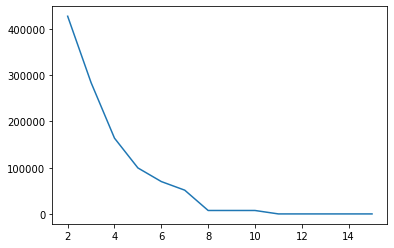

In [21]:
import matplotlib.pyplot as plt

plt.plot(Ks, costs)
plt.show()

In [22]:
kmeans = KMeans(k=8, distanceMeasure='euclidean',
                featuresCol='features', maxIter=100, seed=10)
#kmeans.setWeightCol("weighCol") don't understand what this parameter means
kmeans

KMeans_61a059b5d095

In [23]:
model = kmeans.fit(health_ml)
#model.save('kmeans')
model.computeCost(health_ml)

7589.814407601991

In [24]:
summary = model.summary
print(summary.k)
print(summary.clusterSizes)

8
[122328, 105271, 59435, 11319, 44210, 12671, 9883, 15992]


In [25]:
model.clusterCenters()

[array([ 0.68797545, -0.91963676, -0.99029269]),
 array([-1.07432727,  1.087383  ,  1.00979982]),
 array([0.68818301, 1.087383  , 1.00979982]),
 array([-1.07432727, -0.91963676,  1.00979982]),
 array([-1.07432727, -0.91963676, -0.99029269]),
 array([ 0.6890881 , -0.91963676,  1.00979982]),
 array([-0.02279442,  1.087383  , -0.99029269]),
 array([ 2.45027817, -0.9147422 , -0.99029269])]

In [26]:
print(sScaler_model.mean)
print(sScaler_model.std)

[1.6096156217774913,0.4582101183650871,0.4951234423747537]
[0.5674394019819508,0.49825119888722635,0.4999768745705744]


In [27]:
cluster_centers = []

for r, clu in enumerate(model.clusterCenters()):
    transformed_attributes = []
    for c, attr in enumerate(clu):
        #print("{} + ({} * {}) =".format(sScaler_model.mean[c], attr, sScaler_model.std[c]), end= " ")
        #print(sScaler_model.mean[c] + (attr * sScaler_model.std[c]))
        transformed_attributes.append(round(sScaler_model.mean[c] + (attr * sScaler_model.std[c])))
    #print()
    cluster_centers.append(transformed_attributes)
cluster_centers

[[2, 0, 0],
 [1, 1, 1],
 [2, 1, 1],
 [1, 0, 1],
 [1, 0, 0],
 [2, 0, 1],
 [2, 1, 0],
 [3, 0, 0]]

In [28]:
transformed = model.transform(health_ml).select('features', 'prediction')

In [29]:
transformed.show()

+--------------------+----------+
|            features|prediction|
+--------------------+----------+
|[2.45027816779409...|         7|
+--------------------+----------+
only showing top 1 row



In [45]:
transformed.select('prediction').show()

+----------+
|prediction|
+----------+
|         7|
|         5|
|         7|
|         1|
|         1|
|         4|
|         4|
|         0|
|         1|
|         1|
|         0|
|         1|
|         2|
|         0|
|         2|
|         0|
|         4|
|         1|
|         0|
|         0|
+----------+
only showing top 20 rows



In [51]:
from pyspark.sql.functions import col

In [53]:
col('prediction')

Column<b'prediction'>

In [62]:
health_cl = transformed.select(['prediction']).withColumnRenamed('cluster')
health_cl.show()

TypeError: withColumnRenamed() missing 1 required positional argument: 'new'

In [ ]:
transformed.groupBy('prediction').count().collect()

In [ ]:
transformed.head()

In [ ]:
# separate the dataframe based on cluster label
predictions = transformed.select("prediction").distinct().collect()

In [ ]:
clusters = {}
for pred in predictions:
    clusters[pred.prediction] = transformed.where(transformed["prediction"] == pred.prediction)
    clusters[pred.prediction].toPandas().to_csv('train_cluster_{}.csv'.format(pred.prediction))

In [ ]:
clusters[1]